#### SVI data Analysis

###### American National Standards Institute (ANSI) Codes for States
###### Virginia:VA: 51
###### Maryland:MD: 24
###### West Virginia:WV: 54
###### District of Columbia:DC: 11

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('./data/SVI data/SVI2020_US_county.gdb')

In [3]:
# include only the Washington DC, Virginia, Maryland, and West Virginia(county level)
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['VA', 'MD', 'WV', 'DC'])]

In [4]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

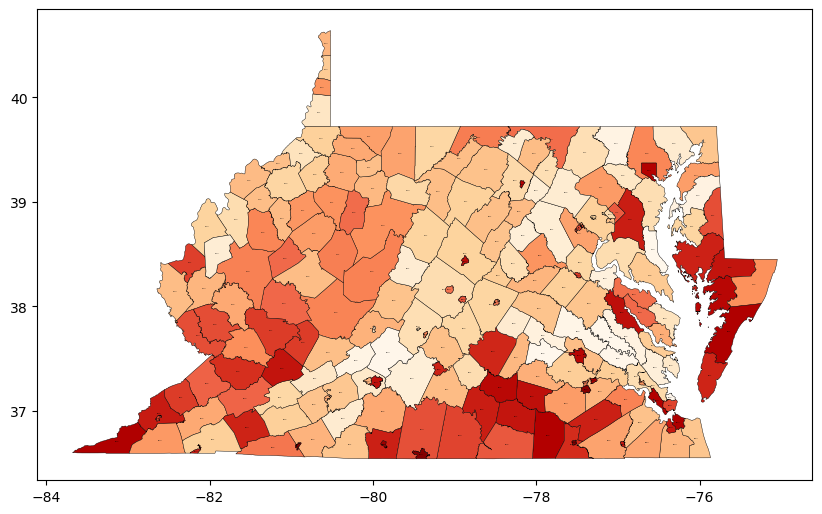

In [5]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

In [6]:
# checking the data type of the FIPS column
print(type(filtered_svi_df['FIPS'][0]))

<class 'str'>


In [7]:
filtered_svi_df.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.1,0.0,0.1,2.9,0.2,0.5,0.1,0.645734,0.018374,"MULTIPOLYGON (((-77.11976 38.93434, -77.11253 ..."
1,24,Maryland,MD,24001,Allegany,24001,"Allegany County, Maryland",422.203330,71002,0,...,0.1,0.0,0.1,2.2,0.4,0.1,0.1,2.647485,0.116232,"MULTIPOLYGON (((-79.06756 39.47944, -79.06003 ..."
2,24,Maryland,MD,24003,Anne Arundel,24003,"Anne Arundel County, Maryland",414.809757,575421,0,...,0.1,0.0,0.1,4.2,0.4,0.3,0.1,2.222859,0.121041,"MULTIPOLYGON (((-76.83849 39.10421, -76.83047 ..."


#### Overdose data (2020)
we need to combine Overdose data to the svi dataframe

In [8]:

# this contains mortality data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
mortality_df = pd.read_csv('./data/Mortality data/Current Final Multiple Cause of Death Data/DCMetroDeaths_2018_2021.csv')

In [9]:
# rename county code column to FIPS
mortality_df.rename(columns={'County Code':'FIPS'}, inplace=True)

In [10]:
# convert FIPS column to string
mortality_df['FIPS'] = mortality_df['FIPS'].astype(str)

In [11]:
# filtering the mortality data for year 2020
mortality_df_2020 = mortality_df[mortality_df['Year']==2020]
mortality_df_2020.reset_index(drop=True, inplace=True)

In [12]:
mortality_df_2020.head(3)

,State,County,FIPS,Year,Year Code,Deaths,Population,Crude Rate
0,WV,"Barbour County, WV",54001,2020,2020,Suppressed,16444,Suppressed
1,WV,"Berkeley County, WV",54003,2020,2020,112,122125,91.7
2,WV,"Boone County, WV",54005,2020,2020,24,21055,114


In [13]:
# Assuming filtered_df has the 'od_deaths' column
od_deaths_counts = mortality_df_2020['Deaths'].value_counts()

# Print the counts of each unique value in the 'od_deaths' column
print(od_deaths_counts)

Suppressed    95
10            10
12             6
0              5
17             5
18             5
11             4
22             4
19             3
16             3
38             3
21             3
13             3
33             3
24             3
30             2
112            2
29             2
37             2
23             2
60             2
49             2
35             2
26             2
99             2
15             2
52             2
34             2
14             2
194            1
106            1
80             1
442            1
59             1
36             1
149            1
227            1
122            1
104            1
46             1
20             1
849            1
280            1
53             1
75             1
146            1
54             1
87             1
69             1
65             1
111            1
28             1
121            1
126            1
103            1
39             1
40             1
67             1
432           

In [14]:
# Merge the dataframes on the 'FIPS' column(this will include all the 2020 data for the Washington DC, Virginia, Maryland, and West Virginia(county level))
merged_df_VA_MD_DC_WV = pd.merge(filtered_svi_df, mortality_df_2020[['FIPS', 'Deaths']],
                     on='FIPS', how='left')

In [15]:

# Rename the 'Provisional Drug Overdose Deaths' column to 'od_deaths'
# merged_df.rename(columns={'Provisional Drug Overdose Deaths': 'od_deaths'}, inplace=True)

# If there are NaN values in 'od_deaths' column, you can fill them with a default value, for example, 0
# merged_df['Deaths'].fillna(0, inplace=True)

# Now, merged_df contains the new column 'od_deaths' based on matching FIPS codes

In [16]:
merged_df_VA_MD_DC_WV.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.0,0.1,2.9,0.2,0.5,0.1,0.645734,0.018374,"MULTIPOLYGON (((-77.11976 38.93434, -77.11253 ...",432
1,24,Maryland,MD,24001,Allegany,24001,"Allegany County, Maryland",422.203330,71002,0,...,0.0,0.1,2.2,0.4,0.1,0.1,2.647485,0.116232,"MULTIPOLYGON (((-79.06756 39.47944, -79.06003 ...",52
2,24,Maryland,MD,24003,Anne Arundel,24003,"Anne Arundel County, Maryland",414.809757,575421,0,...,0.0,0.1,4.2,0.4,0.3,0.1,2.222859,0.121041,"MULTIPOLYGON (((-76.83849 39.10421, -76.83047 ...",280


##### Now I need to extract specifically Washington DC Metropolitan Area SVI dataset.

In [17]:
# this contais Washington DC Metro area counties(shapefile)
metro_map_df = gpd.read_file('./data/DC_Metro_counties/Washington_Arlington_Alexandria_DC_VA_MD_WV_Counties.shp')

In [18]:
metro_map_df.head(3)

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,Shape_Area,CBSAFP,METDIVFP,CSAFP,CBSA_Title,M_Status,MDIV_Title,CSA_Title,C_Status,geometry
0,734,54,037,01550025,54037,Jefferson,Jefferson County,06,H1,G4020,...,0.057252,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outlying,"POLYGON ((-78.03541 39.27841, -78.03526 39.278..."
1,1266,24,009,01676636,24009,Calvert,Calvert County,06,H1,G4020,...,0.092340,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outlying,"POLYGON ((-76.56813 38.40771, -76.57181 38.408..."
2,1297,24,033,01714670,24033,Prince George's,Prince George's County,06,H1,G4020,...,0.134028,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Central,"POLYGON ((-77.04202 38.74672, -77.04191 38.750..."


In [19]:
# In the metro shapefile GEOID contains the FIPS code
# metro_svi_deaths will contains SVI and fatalities data for the Washington DC Metro area counties
metro_svi_deaths = merged_df_VA_MD_DC_WV[merged_df_VA_MD_DC_WV['FIPS'].isin(metro_map_df['GEOID'].tolist())]
metro_svi_deaths.reset_index(drop=True, inplace=True)

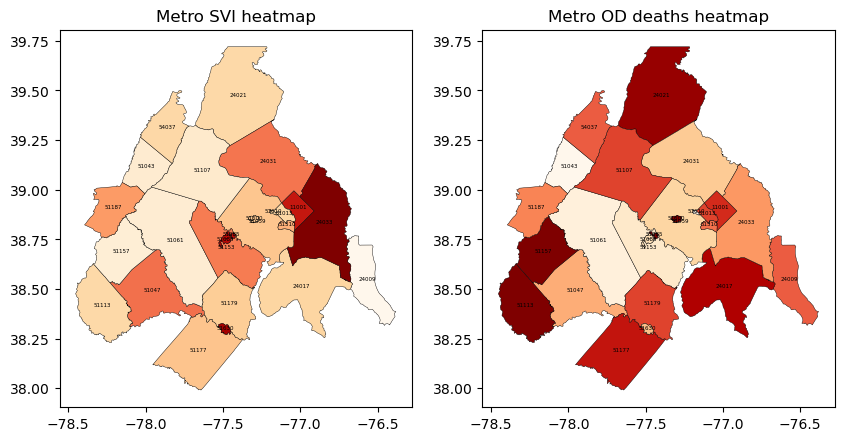

In [20]:
# Plot the data side by side using subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plot for filtered_result (assuming filtered_result is your filtered dataframe)
ax1 = metro_svi_deaths.plot(ax=axes[0], column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax1.set_title('Metro SVI heatmap')

# Plot for filtered_merged_df (assuming filtered_merged_df is your first filtered dataframe)
ax2 = metro_svi_deaths.plot(ax=axes[1], column="Deaths", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax2.set_title('Metro OD deaths heatmap')

# Annotate the plots
for ax in [ax1, ax2]:
    for idx, row in metro_svi_deaths.iterrows():
        centroid = row.geometry.centroid
        county_name = row.FIPS
        ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=4)

# Display the plots
plt.show()

In [21]:
metro_svi_deaths

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.0,0.1,2.9,0.2,0.5,0.1,0.645734,0.018374,"MULTIPOLYGON (((-77.11976 38.93434, -77.11253 ...",432
1,24,Maryland,MD,24009,Calvert,24009,"Calvert County, Maryland",213.189517,92094,0,...,0.0,0.1,3.8,0.6,0.1,0.2,1.392130,0.063610,"MULTIPOLYGON (((-76.70121 38.71276, -76.69914 ...",33
2,24,Maryland,MD,24017,Charles,24017,"Charles County, Maryland",457.823473,161448,0,...,0.0,0.1,4.7,0.7,0.4,0.2,2.164637,0.129562,"MULTIPOLYGON (((-77.27382 38.48356, -77.27240 ...",60
3,24,Maryland,MD,24021,Frederick,24021,"Frederick County, Maryland",660.590349,255955,0,...,0.1,0.1,3.3,0.3,0.2,0.1,2.120478,0.180981,"MULTIPOLYGON (((-77.67716 39.32453, -77.67637 ...",80
4,24,Maryland,MD,24031,Montgomery,24031,"Montgomery County, Maryland",493.109662,1047661,0,...,0.0,0.1,3.7,0.2,0.7,0.1,1.841432,0.136786,"MULTIPOLYGON (((-77.52728 39.14624, -77.52487 ...",149
5,24,Maryland,MD,24033,Prince George's,24033,"Prince George's County, Maryland",482.649590,910551,0,...,0.0,0.1,2.7,0.2,0.5,0.1,2.146588,0.134026,"MULTIPOLYGON (((-77.07995 38.70901, -77.08080 ...",227
6,51,Virginia,VA,51013,Arlington,51013,"Arlington County, Virginia",25.997402,236434,0,...,0.1,0.1,3.8,0.4,0.5,0.2,0.403757,0.006995,"MULTIPOLYGON (((-77.17228 38.89325, -77.16811 ...",38
7,51,Virginia,VA,51043,Clarke,51043,"Clarke County, Virginia",175.932838,14498,0,...,0.0,0.3,1.9,1.0,0.5,0.7,1.030180,0.048052,"MULTIPOLYGON (((-78.15170 39.03667, -78.14240 ...",0
8,51,Virginia,VA,51047,Culpeper,51047,"Culpeper County, Virginia",379.186591,51935,0,...,0.1,0.2,4.2,1.1,0.5,0.5,2.099423,0.102349,"MULTIPOLYGON (((-78.22915 38.53328, -78.22896 ...",19
9,51,Virginia,VA,51059,Fairfax,51059,"Fairfax County, Virginia",391.020748,1149439,0,...,0.1,0.1,3.9,0.2,0.4,0.1,2.138721,0.108028,"MULTIPOLYGON (((-77.53698 38.84275, -77.53496 ...",121


In [22]:
# make "Suppressed" values in the Deaths column to 5   
metro_svi_deaths['Deaths'].replace('Suppressed', 5, inplace=True)

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_38102/506533984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metro_svi_deaths['Deaths'].replace('Suppressed', 5, inplace=True)


In [23]:
# check the data type of the Deaths column
print(type(metro_svi_deaths['Deaths'][0]))

<class 'str'>


In [24]:
# convert Deaths column to float
metro_svi_deaths['Deaths'] = metro_svi_deaths['Deaths'].astype(float)

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
# create a new column 'od_deaths_per_1000' which is the ratio of 'od_deaths' to 'E_TOTPOP' and multiply by 1000
metro_svi_deaths['od_deaths_per_1000'] = (metro_svi_deaths['Deaths']/metro_svi_deaths['E_TOTPOP'])*1000

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [26]:
metro_svi_deaths

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths,od_deaths_per_1000
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.1,2.9,0.2,0.5,0.1,0.645734,0.018374,"MULTIPOLYGON (((-77.11976 38.93434, -77.11253 ...",432.0,0.615407
1,24,Maryland,MD,24009,Calvert,24009,"Calvert County, Maryland",213.189517,92094,0,...,0.1,3.8,0.6,0.1,0.2,1.392130,0.063610,"MULTIPOLYGON (((-76.70121 38.71276, -76.69914 ...",33.0,0.358330
2,24,Maryland,MD,24017,Charles,24017,"Charles County, Maryland",457.823473,161448,0,...,0.1,4.7,0.7,0.4,0.2,2.164637,0.129562,"MULTIPOLYGON (((-77.27382 38.48356, -77.27240 ...",60.0,0.371637
3,24,Maryland,MD,24021,Frederick,24021,"Frederick County, Maryland",660.590349,255955,0,...,0.1,3.3,0.3,0.2,0.1,2.120478,0.180981,"MULTIPOLYGON (((-77.67716 39.32453, -77.67637 ...",80.0,0.312555
4,24,Maryland,MD,24031,Montgomery,24031,"Montgomery County, Maryland",493.109662,1047661,0,...,0.1,3.7,0.2,0.7,0.1,1.841432,0.136786,"MULTIPOLYGON (((-77.52728 39.14624, -77.52487 ...",149.0,0.142222
5,24,Maryland,MD,24033,Prince George's,24033,"Prince George's County, Maryland",482.649590,910551,0,...,0.1,2.7,0.2,0.5,0.1,2.146588,0.134026,"MULTIPOLYGON (((-77.07995 38.70901, -77.08080 ...",227.0,0.249300
6,51,Virginia,VA,51013,Arlington,51013,"Arlington County, Virginia",25.997402,236434,0,...,0.1,3.8,0.4,0.5,0.2,0.403757,0.006995,"MULTIPOLYGON (((-77.17228 38.89325, -77.16811 ...",38.0,0.160721
7,51,Virginia,VA,51043,Clarke,51043,"Clarke County, Virginia",175.932838,14498,0,...,0.3,1.9,1.0,0.5,0.7,1.030180,0.048052,"MULTIPOLYGON (((-78.15170 39.03667, -78.14240 ...",0.0,0.000000
8,51,Virginia,VA,51047,Culpeper,51047,"Culpeper County, Virginia",379.186591,51935,0,...,0.2,4.2,1.1,0.5,0.5,2.099423,0.102349,"MULTIPOLYGON (((-78.22915 38.53328, -78.22896 ...",19.0,0.365842
9,51,Virginia,VA,51059,Fairfax,51059,"Fairfax County, Virginia",391.020748,1149439,0,...,0.1,3.9,0.2,0.4,0.1,2.138721,0.108028,"MULTIPOLYGON (((-77.53698 38.84275, -77.53496 ...",121.0,0.105269


#### Now we need to select the socioeconmics variables and deaths data to create a prediction model to find most important variables
'E_TOTPOP','EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','EP_NOINT','EP_AFAM','EP_HISP','EP_ASIAN','EP_AIAN','EP_NHPI','EP_TWOMORE','EP_OTHERRACE','od_deaths_per_1000'

##### Socioeconomic variables
###### EP_POV150    Percentage of persons below 150% poverty estimate
###### EP_UNEMP    Unemployment Rate estimate
###### EP_HBURD    Percentage of housing cost-burdened occupied housing units with annual income less than $75,000 (30%+ of income spent on housing costs) estimate, 2016-2020 ACS estimate, 2016-2020 ACS
###### EP_NOHSDP   Percentage of persons with no high school diploma (age 25+) estimate
###### EP_UNINSUR  Percentage uninsured in the total civilian noninstitutionalized population estimate, 2016-2020 ACS

In [27]:
# socioeconomic variable into a list
socioeconomic_variable_names = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR']

In [28]:
# filter metro_svi_deaths dataframe to include only the socioeconomic variables and od_deaths_per_1000
metro_svi_deaths_socioeconomic = metro_svi_deaths[socioeconomic_variable_names + ['od_deaths_per_1000']]

In [29]:
metro_svi_deaths_socioeconomic

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,od_deaths_per_1000
0,21.3,7.1,27.2,8.1,3.7,0.615407
1,8.0,3.8,19.0,5.7,3.3,0.358330
2,10.9,4.4,21.8,6.4,4.2,0.371637
3,10.4,4.1,21.4,7.4,4.5,0.312555
4,11.7,4.6,24.0,8.6,6.8,0.142222
5,14.2,6.4,29.8,12.8,10.3,0.249300
6,10.4,2.8,21.2,5.1,6.0,0.160721
7,11.0,3.0,23.4,8.3,8.7,0.000000
8,14.2,4.0,23.3,12.9,9.6,0.365842
9,10.0,4.1,20.0,7.3,8.1,0.105269


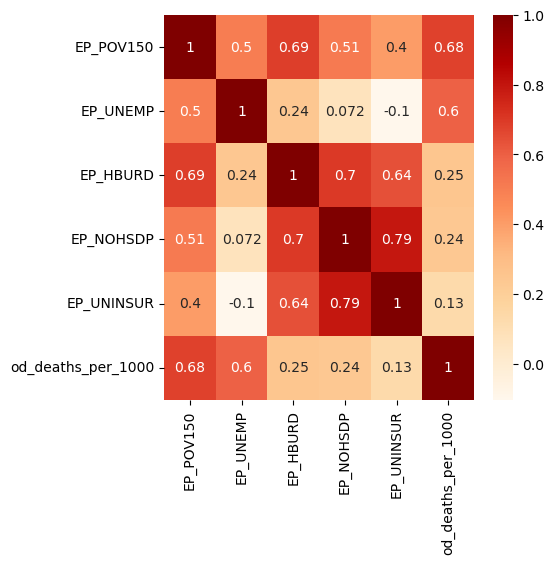

In [30]:
# create a correlation matrix
corr_matrix = metro_svi_deaths_socioeconomic.corr()

# plot the correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='OrRd')   
plt.show()

In [54]:
# split the metro_svi_deaths_socioeconomic data into train and test sets
from sklearn.model_selection import train_test_split

In [55]:
# create X and y
X = metro_svi_deaths_socioeconomic.drop('od_deaths_per_1000', axis=1)
y = metro_svi_deaths_socioeconomic['od_deaths_per_1000']

In [33]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

### Feature Selection Methods

### Wrapper feature selection methods

#### 1. Forward Feature Selection


In [60]:
selectedVariables = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','od_deaths_per_1000']

In [62]:
# filter metro_svi_deaths dataframe to include only the selected variables and od_deaths_per_1000
metroSviMultipleVariablesDf = metro_svi_deaths[selectedVariables]

In [63]:
# create X and y
X = metroSviMultipleVariablesDf.drop('od_deaths_per_1000', axis=1)
y = metroSviMultipleVariablesDf['od_deaths_per_1000']

In [76]:
#forward feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [73]:
# calling the linear regression model

lreg = LinearRegression()
sfs1 = SFS(lreg, k_features=4, forward=True, verbose=2, scoring='neg_mean_squared_error')

In [74]:
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2023-11-08 10:33:14] Features: 1/4 -- score: -0.020635672106346523[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2023-11-08 10:33:15] Features: 2/4 -- score: -0.017257112739309903[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished

[2023-11-08 10:33:15] Features: 3/4 -- score: -0.015423742394538031[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: 

In [75]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

['EP_POV150', 'EP_UNEMP', 'EP_DISABL', 'EP_CROWD']


In [78]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)


[0, 1, 7, 13]
